## Needed Libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from datetime import datetime
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.metrics import mean_absolute_error

### Importing CSV Files and preprocessing ETH Data

In [2]:
# Ethereum Prices and dates
df_eth_prices = pd.read_csv("ETH_Historical_Price.csv") 

# Turn timestamps into dates
df_eth_prices['timestamp'] = [dt.datetime.fromtimestamp(i).strftime('%d-%m-%Y') for i in df_eth_prices['timestamp']]

# Reverse the dataframe based on the dates
df_eth_prices = df_eth_prices.iloc[::-1]

# Preprocess the data
df_eth_prices.drop(['high','low','close'], 1, inplace=True)

# Converting timestamp dates as a datetime object
datelist_train = list(df_eth_prices['timestamp'])
datelist_train = [dt.datetime.strptime(date, '%d-%m-%Y').date() for date in datelist_train]
df_eth_prices['timestamp'] = datelist_train
df_eth_prices.index = df_eth_prices['timestamp']
#df_eth_prices = df_eth_prices.set_index('timestamp')
df_eth_prices = df_eth_prices[513:1249]
df_eth_prices

,timestamp,open
timestamp,,
2017-01-01,2017-01-01,8.14
2017-01-02,2017-01-02,8.33
2017-01-03,2017-01-03,9.59
2017-01-04,2017-01-04,10.88
2017-01-05,2017-01-05,10.20
...,...,...
2019-01-02,2019-01-02,156.57
2019-01-03,2019-01-03,149.44
2019-01-04,2019-01-04,156.04


In [3]:
# Implementing weekly prices and adding them to the ethereum price dataframe

weekly_price_list = []
closing_prices = list(df_eth_prices['open'])

temp_list = []
for i in range(0,len(closing_prices)):
    if (i + 1) % 7 == 0:
        temp_list.append(closing_prices[i])
        weekly_price_list.append(temp_list)
        temp_list = []
    else:
        temp_list.append(closing_prices[i])
        
    
mean_weekly_list = []    
for i in weekly_price_list:
    mean_weekly_list.append(np.mean(i))
    
len(mean_weekly_list)

105

In [4]:
# Reading the ethereum google trends values from 2017 to 2019 then assigning the trend values as integers

trends_weekly_df_eth = pd.read_csv("2017_2019_eth_google_trends.csv")
trends_weekly_df_eth.columns = trends_weekly_df_eth.iloc[0]
trends_weekly_df_eth = trends_weekly_df_eth[1:]
trend_values_eth = trends_weekly_df_eth['Ether: (Dünya Genelinde)']

modify_integers_df = trend_values_eth
new_integers = []
for i in modify_integers_df:
    if(i == "<1"):
        new_integers.append(1)
    else:
        new_integers.append(i)
        
trends_weekly_df_eth.drop(['Ether: (Dünya Genelinde)'], 1, inplace=True)
trends_weekly_df_eth['Trend Values'] = new_integers
trends_weekly_df_eth['Trend Values'] = trends_weekly_df_eth['Trend Values'].astype("int")
trends_weekly_df_eth

Hafta,Trend Values
2017-01-01,2
2017-01-08,2
2017-01-15,3
2017-01-22,3
2017-01-29,1
...,...
2018-12-02,15
2018-12-09,10
2018-12-16,20
2018-12-23,22


In [5]:
main_df = pd.DataFrame() 
main_df['Trend Values'] = trends_weekly_df_eth['Trend Values']
main_df['Mean Weekly Prices'] = mean_weekly_list
main_df['Mean Weekly Prices'] = main_df['Mean Weekly Prices'].astype("float")
main_df

,Trend Values,Mean Weekly Prices
2017-01-01,2,9.570000
2017-01-08,2,10.031429
2017-01-15,3,10.248571
2017-01-22,3,10.601429
2017-01-29,1,10.794286
...,...,...
2018-12-02,15,101.580000
2018-12-09,10,88.321429
2018-12-16,20,104.018571
2018-12-23,22,132.825714


<AxesSubplot:>

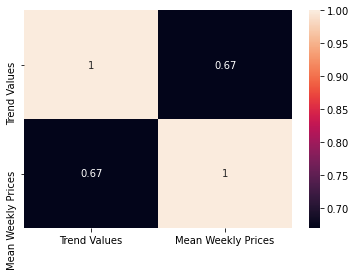

In [6]:
sns.heatmap(main_df.corr(),annot = True)

## Graphs to visualize the Ethereum data

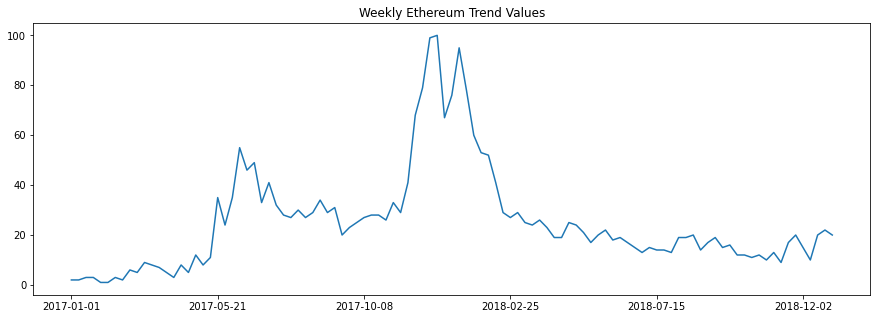

In [7]:
# Mean Weekly Prices For Ethereum
main_df['Trend Values'].plot(figsize=(15, 5))
plt.title("Weekly Ethereum Trend Values")
plt.show()

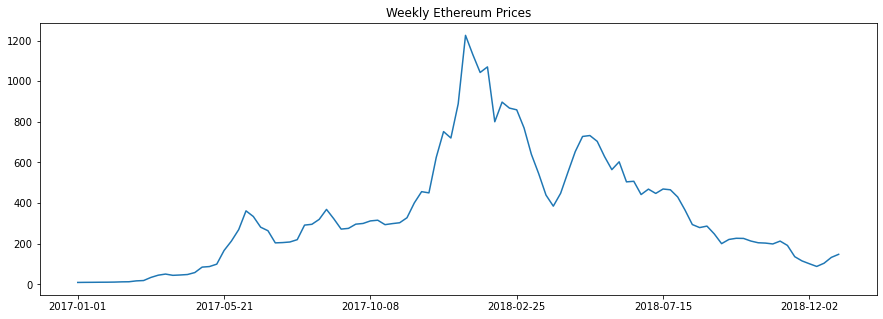

In [8]:
# Mean Weekly Prices For Ethereum
main_df['Mean Weekly Prices'].plot(figsize=(15, 5))
plt.title("Weekly Ethereum Prices")
plt.show()

In [9]:
# Create a week feature
main_df['Week Feature'] = main_df.index
main_df

,Trend Values,Mean Weekly Prices,Week Feature
2017-01-01,2,9.570000,2017-01-01
2017-01-08,2,10.031429,2017-01-08
2017-01-15,3,10.248571,2017-01-15
2017-01-22,3,10.601429,2017-01-22
2017-01-29,1,10.794286,2017-01-29
...,...,...,...
2018-12-02,15,101.580000,2018-12-02
2018-12-09,10,88.321429,2018-12-09
2018-12-16,20,104.018571,2018-12-16
2018-12-23,22,132.825714,2018-12-23


In [10]:
# Check null values
main_df.isnull().sum()

Trend Values          0
Mean Weekly Prices    0
Week Feature          0
dtype: int64

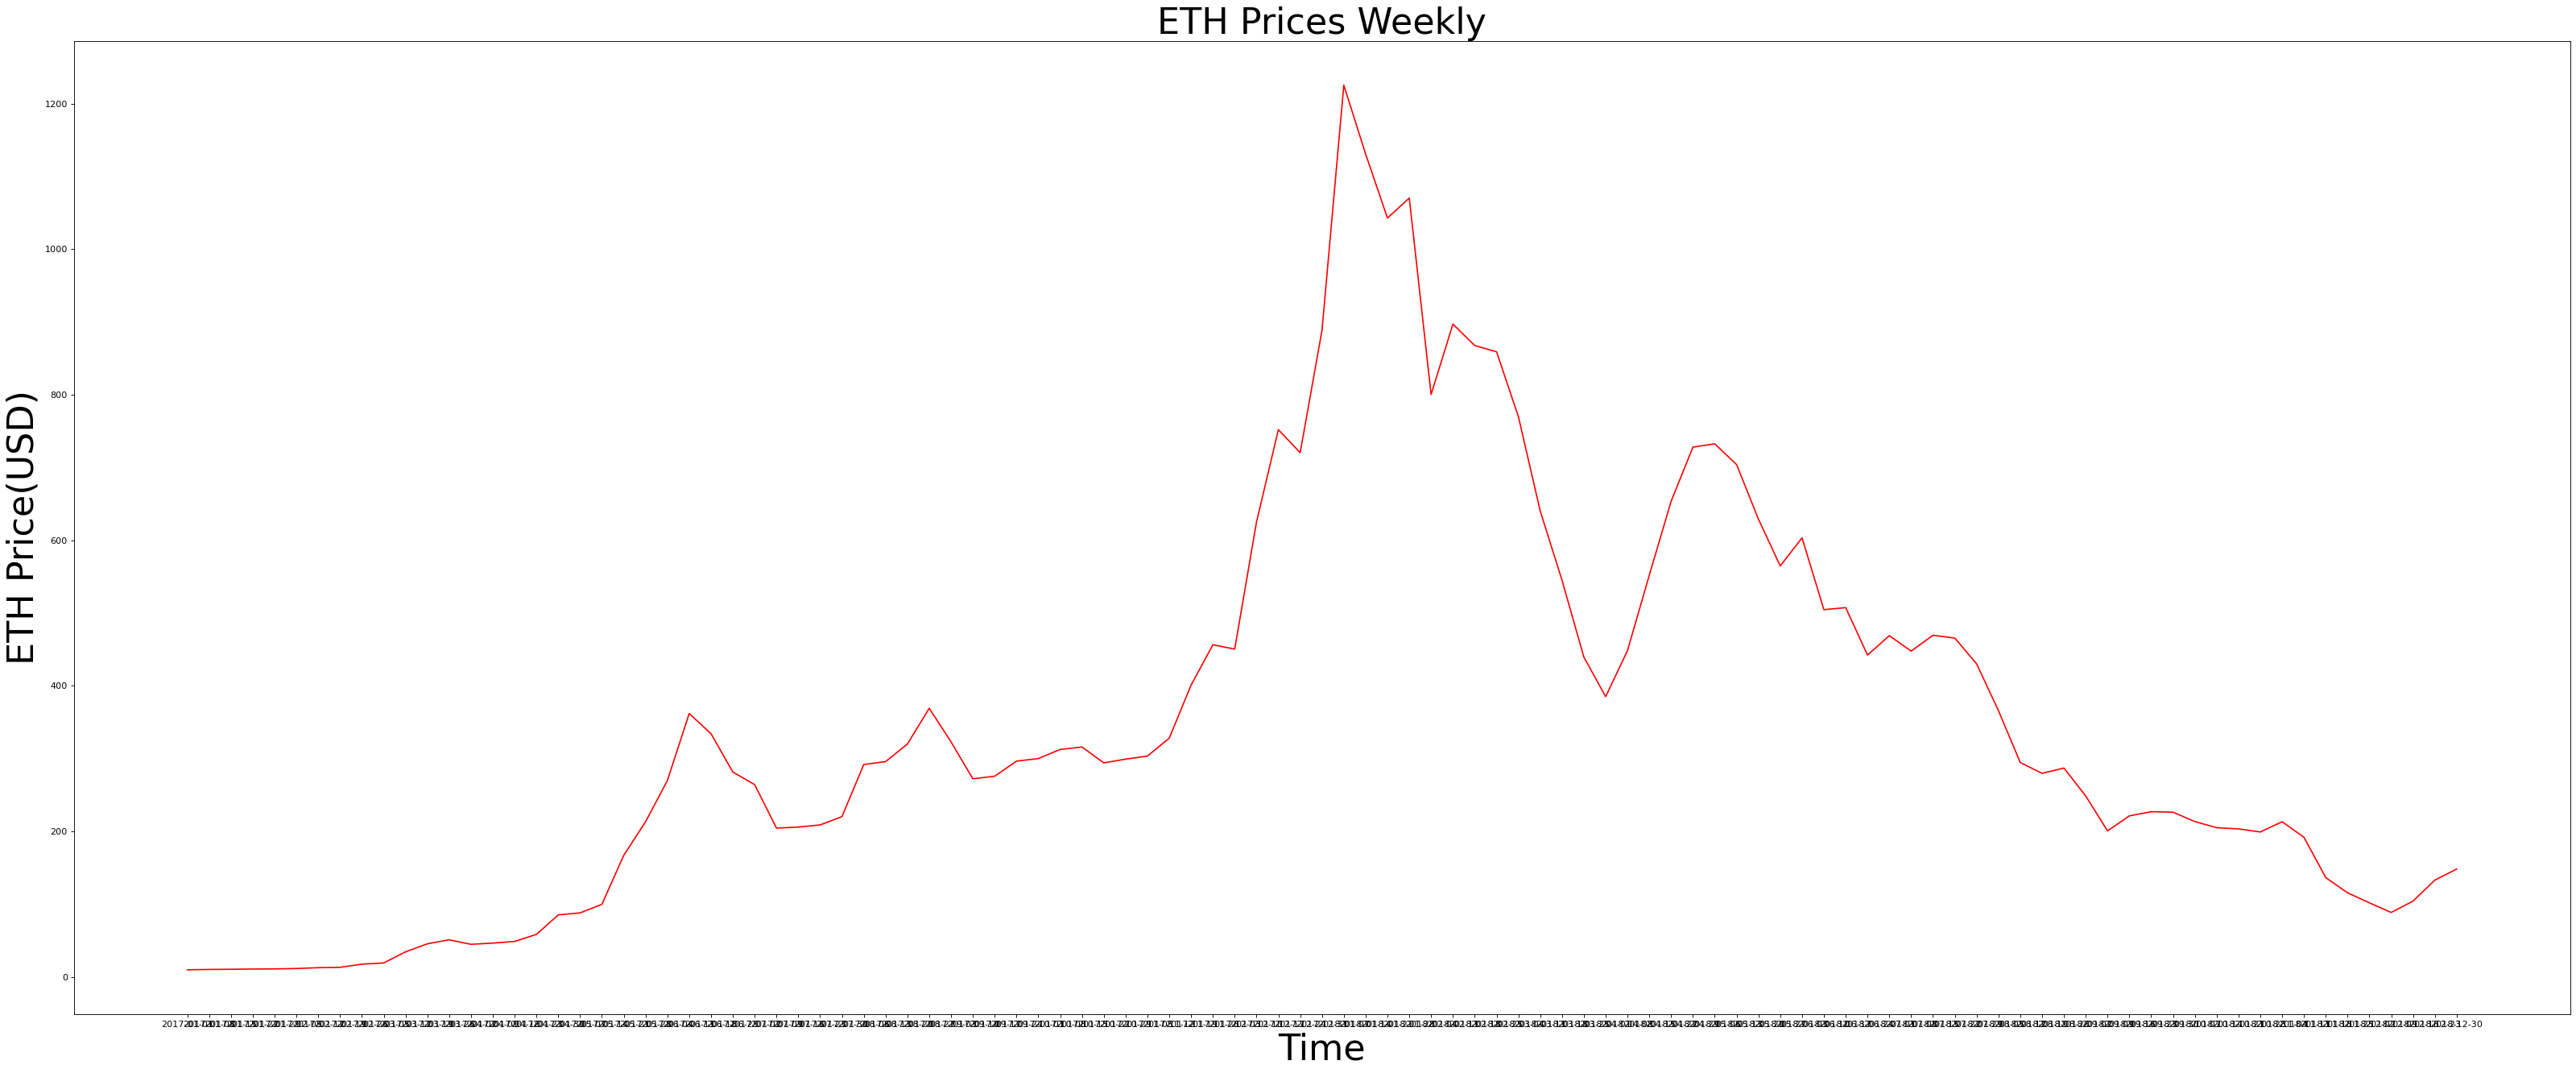

In [11]:
# The Prices of ETH over time
plt.figure(figsize=(50, 20), dpi=80, facecolor = 'w', edgecolor = 'k')
plt.plot(main_df['Mean Weekly Prices'], color='red', label='Real ETH Price')
plt.title('ETH Prices Weekly', fontsize = 40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('ETH Price(USD)', fontsize = 40)
plt.show()

## Shifting Data to the right

In [12]:
main_df['Shifted Mean Prices'] = main_df['Mean Weekly Prices'].shift(1, axis = 0) 
main_df['Trends Shifted'] = main_df['Trend Values'].shift(1, axis = 0)
main_df = main_df[1:]
main_df

,Trend Values,Mean Weekly Prices,Week Feature,Shifted Mean Prices,Trends Shifted
2017-01-08,2,10.031429,2017-01-08,9.570000,2.0
2017-01-15,3,10.248571,2017-01-15,10.031429,2.0
2017-01-22,3,10.601429,2017-01-22,10.248571,3.0
2017-01-29,1,10.794286,2017-01-29,10.601429,3.0
2017-02-05,1,11.298571,2017-02-05,10.794286,1.0
...,...,...,...,...,...
2018-12-02,15,101.580000,2018-12-02,115.362857,20.0
2018-12-09,10,88.321429,2018-12-09,101.580000,15.0
2018-12-16,20,104.018571,2018-12-16,88.321429,10.0
2018-12-23,22,132.825714,2018-12-23,104.018571,20.0


### Splitting the data for train and test

In [13]:
# Converting dates as a datetime object

datelist_train = list(main_df['Week Feature'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]
main_df.index = datelist_train
main_df

,Trend Values,Mean Weekly Prices,Week Feature,Shifted Mean Prices,Trends Shifted
2017-01-08,2,10.031429,2017-01-08,9.570000,2.0
2017-01-15,3,10.248571,2017-01-15,10.031429,2.0
2017-01-22,3,10.601429,2017-01-22,10.248571,3.0
2017-01-29,1,10.794286,2017-01-29,10.601429,3.0
2017-02-05,1,11.298571,2017-02-05,10.794286,1.0
...,...,...,...,...,...
2018-12-02,15,101.580000,2018-12-02,115.362857,20.0
2018-12-09,10,88.321429,2018-12-09,101.580000,15.0
2018-12-16,20,104.018571,2018-12-16,88.321429,10.0
2018-12-23,22,132.825714,2018-12-23,104.018571,20.0


In [20]:
# Data Types
main_df.dtypes

Trend Values             int32
Mean Weekly Prices     float64
Week Feature            object
Shifted Mean Prices    float64
Trends Shifted         float64
dtype: object

In [14]:
# Splitting the data to train and test based on the prediction day we want

date_string = "21 May, 2018"
#possible parameter %H:%M:%S
dt_onject_split = dt.datetime.strptime(date_string, "%d %B, %Y").date()
data_train = main_df.loc[main_df.index <= dt_onject_split].copy()
data_test = main_df.loc[main_df.index > dt_onject_split].copy()

print("Data train shape",data_train.shape)
print("Data test shape",data_test.shape)

Data train shape (72, 5)
Data test shape (32, 5)


In [21]:
def create_features_with_google_trends(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['Hafta'] = df.index
    df['Hafta'] = pd.to_datetime(df['Hafta'], errors='coerce')
    df['Month'] = df['Hafta'].dt.month
    df['Year'] = df['Hafta'].dt.year
    df['Day of Month'] = df['Hafta'].dt.day

    
    X = df[['Month','Year','Day of Month','Trends Shifted', 'Shifted Mean Prices']]
    if label:
        y = df[label]
        return X, y
    return X



def create_features_without_google_trends(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['Hafta'] = df.index
    df['Hafta'] = pd.to_datetime(df['Hafta'], errors='coerce')
    df['Month'] = df['Hafta'].dt.month
    df['Year'] = df['Hafta'].dt.year
    df['Day of Month'] = df['Hafta'].dt.day

    
    X = df[['Month','Year','Day of Month', 'Shifted Mean Prices']]
    if label:
        y = df[label]
        return X, y
    return X

### Create train and test data

In [23]:
X_train, y_train = create_features_with_google_trends(data_train, label='Mean Weekly Prices')
X_test, y_test = create_features_with_google_trends(data_test, label='Mean Weekly Prices')

X_train['Trends Shifted'] = X_train['Trends Shifted'].astype(int)
X_test['Trends Shifted'] = X_test['Trends Shifted'].astype(int)

X_train

<ipython-input-23-fc22c53f1bce>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Trends Shifted'] = X_train['Trends Shifted'].astype(int)
<ipython-input-23-fc22c53f1bce>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Trends Shifted'] = X_test['Trends Shifted'].astype(int)


,Month,Year,Day of Month,Trends Shifted,Shifted Mean Prices
2017-01-08,1,2017,8,2,9.570000
2017-01-15,1,2017,15,2,10.031429
2017-01-22,1,2017,22,3,10.248571
2017-01-29,1,2017,29,3,10.601429
2017-02-05,2,2017,5,1,10.794286
...,...,...,...,...,...
2018-04-22,4,2018,22,19,552.030000
2018-04-29,4,2018,29,25,653.477143
2018-05-06,5,2018,6,24,727.901429
2018-05-13,5,2018,13,21,732.414286


In [24]:
X_train_second, y_train_second = create_features_without_google_trends(data_train, label='Mean Weekly Prices')
X_test_second, y_test_second = create_features_without_google_trends(data_test, label='Mean Weekly Prices')


X_train_second

,Month,Year,Day of Month,Shifted Mean Prices
2017-01-08,1,2017,8,9.570000
2017-01-15,1,2017,15,10.031429
2017-01-22,1,2017,22,10.248571
2017-01-29,1,2017,29,10.601429
2017-02-05,2,2017,5,10.794286
...,...,...,...,...
2018-04-22,4,2018,22,552.030000
2018-04-29,4,2018,29,653.477143
2018-05-06,5,2018,6,727.901429
2018-05-13,5,2018,13,732.414286


## Create an LSTM model. 

In [25]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

In [26]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
min_max_scaler_y = MinMaxScaler()

In [27]:
# Turning input X_Train to appropriate shape for LSTM    ((n_samples, time_steps, features))
x_training_set = X_train.values
x_training_set = x_training_set[0:len(x_training_set)]

x_training_set = min_max_scaler.fit_transform(x_training_set)
x_training_set = x_training_set.reshape((x_training_set.shape[0], 1, x_training_set.shape[1]))

y_train = pd.DataFrame(y_train)
list(y_train['Mean Weekly Prices'])
y_train_values = [float(i) for i in y_train['Mean Weekly Prices']]
y_train_values = np.array(y_train_values)
y_train_values = np.array(y_train_values)

y_train_values = np.reshape(y_train_values, (len(y_train_values), 1))
y_training_set = min_max_scaler_y.fit_transform(y_train_values)

In [28]:
# Initialize the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 50, input_shape=(x_training_set.shape[1], x_training_set.shape[2])))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Using the training set to train the model
regressor.fit(x_training_set, y_training_set, batch_size = 5, epochs = 100)

Epoch 1/100
15/15 [==============================] - 2s 924us/step - loss: 0.1348
Epoch 2/100
15/15 [==============================] - 0s 926us/step - loss: 0.0985
Epoch 3/100
15/15 [==============================] - 0s 926us/step - loss: 0.0385
Epoch 4/100
15/15 [==============================] - 0s 855us/step - loss: 0.0351
Epoch 5/100
15/15 [==============================] - 0s 855us/step - loss: 0.0248
Epoch 6/100
15/15 [==============================] - 0s 855us/step - loss: 0.0180
Epoch 7/100
15/15 [==============================] - 0s 926us/step - loss: 0.0154
Epoch 8/100
15/15 [==============================] - 0s 1ms/step - loss: 0.0161
Epoch 9/100
15/15 [==============================] - 0s 926us/step - loss: 0.0113
Epoch 10/100
15/15 [==============================] - 0s 926us/step - loss: 0.0096
Epoch 11/100
15/15 [==============================] - 0s 926us/step - loss: 0.0075
Epoch 12/100
15/15 [==============================] - 0s 926us/step - loss: 0.0074
Epoch 13/100
15

15/15 [==============================] - 0s 926us/step - loss: 0.0047
Epoch 100/100
15/15 [==============================] - 0s 997us/step - loss: 0.0025


In [29]:
test_set = X_test.values

# Reshaping and scaling the inputs
inputs = np.reshape(test_set, (len(test_set), 5))
inputs = min_max_scaler.transform(inputs)
inputs = inputs.reshape((inputs.shape[0], 1, 5))
predicted_price = regressor.predict(inputs)
inputs = inputs.reshape((inputs.shape[0], 1, 5))
predicted_price = min_max_scaler_y.inverse_transform(predicted_price)


In [30]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,predicted_price,squared=False)

205.16040398427455

In [31]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test,predicted_price)

184.61309150695803

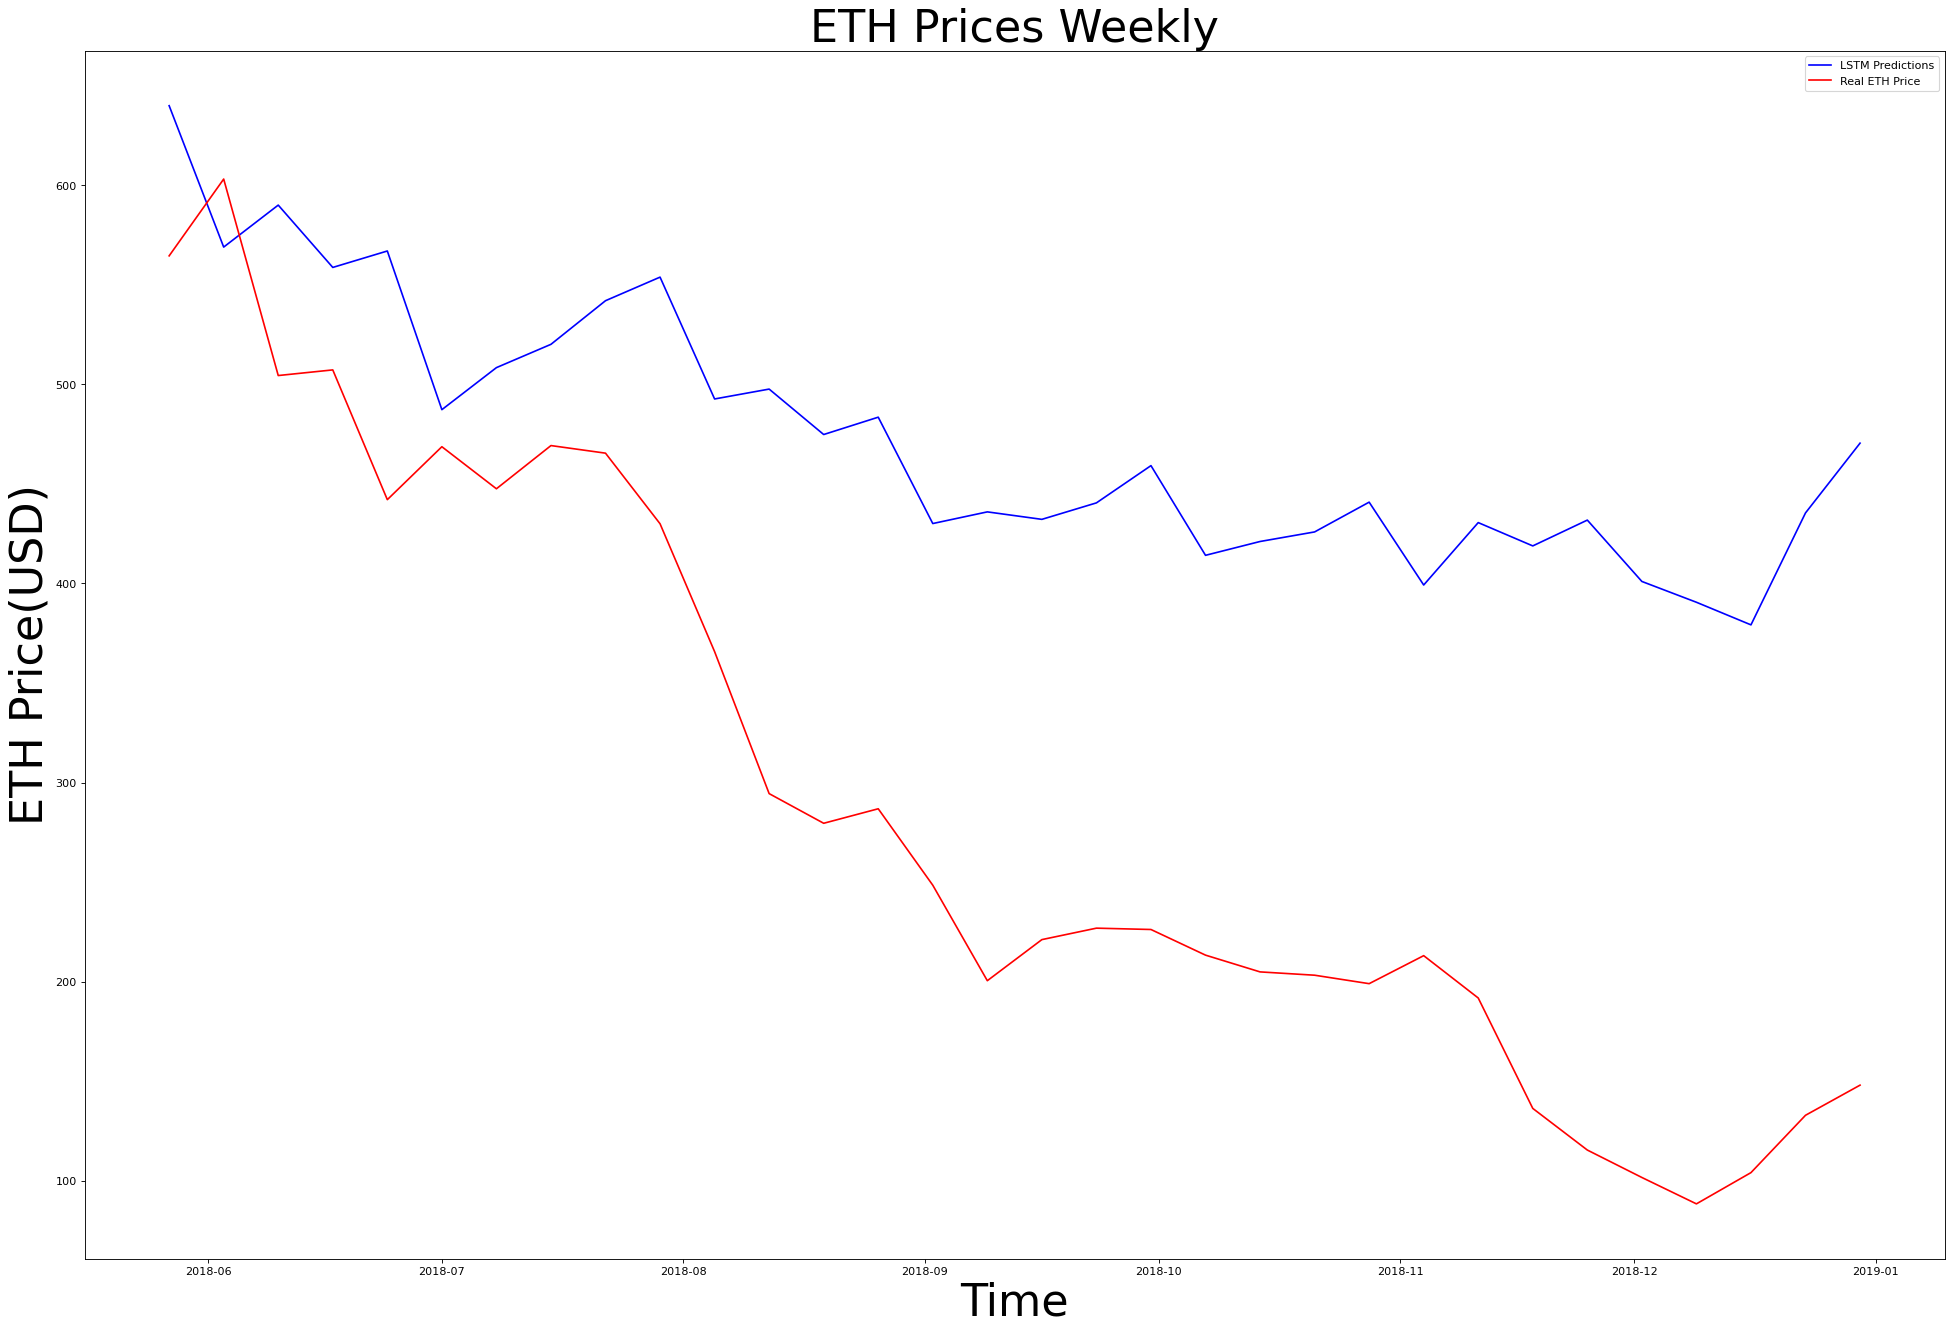

In [32]:
y_test_values = [float(i) for i in y_test]

plt.figure(figsize=(30, 20), dpi=80, facecolor = 'w', edgecolor = 'k')
plt.plot(X_test.index,predicted_price, color='blue', label='LSTM Predictions')
plt.plot(X_test.index,y_test_values, color='red', label='Real ETH Price')
plt.title('ETH Prices Weekly', fontsize = 40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('ETH Price(USD)', fontsize = 40)
plt.legend()
plt.show()

In [33]:
# Previous predicted prices were for feaures with google trends, now predicting for without google trends 
from sklearn.preprocessing import MinMaxScaler
min_max_scaler_second = MinMaxScaler()
min_max_scaler_y_second = MinMaxScaler()

In [34]:
# Turning input X_Train to appropriate shape for LSTM    ((n_samples, time_steps, features))
x_training_set = X_train_second.values
x_training_set = x_training_set[0:len(x_training_set)]

x_training_set = min_max_scaler_second.fit_transform(x_training_set)
x_training_set = x_training_set.reshape((x_training_set.shape[0], 1, x_training_set.shape[1]))

In [35]:
y_train = pd.DataFrame(y_train_second)
list(y_train['Mean Weekly Prices'])
y_train_values = [float(i) for i in y_train['Mean Weekly Prices']]
y_train_values = np.array(y_train_values)
y_train_values = np.array(y_train_values)

y_train_values = np.reshape(y_train_values, (len(y_train_values), 1))
y_training_set = min_max_scaler_y_second.fit_transform(y_train_values)

In [36]:
# Initialize the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 50, input_shape=(x_training_set.shape[1], x_training_set.shape[2])))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Using the training set to train the model
regressor.fit(x_training_set, y_training_set, batch_size = 5, epochs = 100)

Epoch 1/100
15/15 [==============================] - 2s 926us/step - loss: 0.1934
Epoch 2/100
15/15 [==============================] - 0s 855us/step - loss: 0.1352
Epoch 3/100
15/15 [==============================] - 0s 855us/step - loss: 0.0596
Epoch 4/100
15/15 [==============================] - 0s 855us/step - loss: 0.0405
Epoch 5/100
15/15 [==============================] - 0s 855us/step - loss: 0.0251
Epoch 6/100
15/15 [==============================] - 0s 997us/step - loss: 0.0263
Epoch 7/100
15/15 [==============================] - 0s 926us/step - loss: 0.0285
Epoch 8/100
15/15 [==============================] - 0s 926us/step - loss: 0.0187
Epoch 9/100
15/15 [==============================] - 0s 926us/step - loss: 0.0183
Epoch 10/100
15/15 [==============================] - 0s 855us/step - loss: 0.0133
Epoch 11/100
15/15 [==============================] - 0s 855us/step - loss: 0.0127
Epoch 12/100
15/15 [==============================] - 0s 926us/step - loss: 0.0133
Epoch 13/100


15/15 [==============================] - 0s 855us/step - loss: 0.0026
Epoch 100/100
15/15 [==============================] - 0s 997us/step - loss: 0.0041


In [37]:
test_set = X_test_second.values

# Reshaping and scaling the inputs
inputs = np.reshape(test_set, (len(test_set), 4))
inputs = min_max_scaler_second.transform(inputs)
inputs = inputs.reshape((inputs.shape[0], 1, 4))
predicted_price = regressor.predict(inputs)
inputs = inputs.reshape((inputs.shape[0], 1, 4))
predicted_price = min_max_scaler_y_second.inverse_transform(predicted_price)

In [38]:
mean_squared_error(y_test,predicted_price,squared=False)

95.32519208338428

In [40]:
mean_absolute_error(y_test,predicted_price)

88.9278921863011

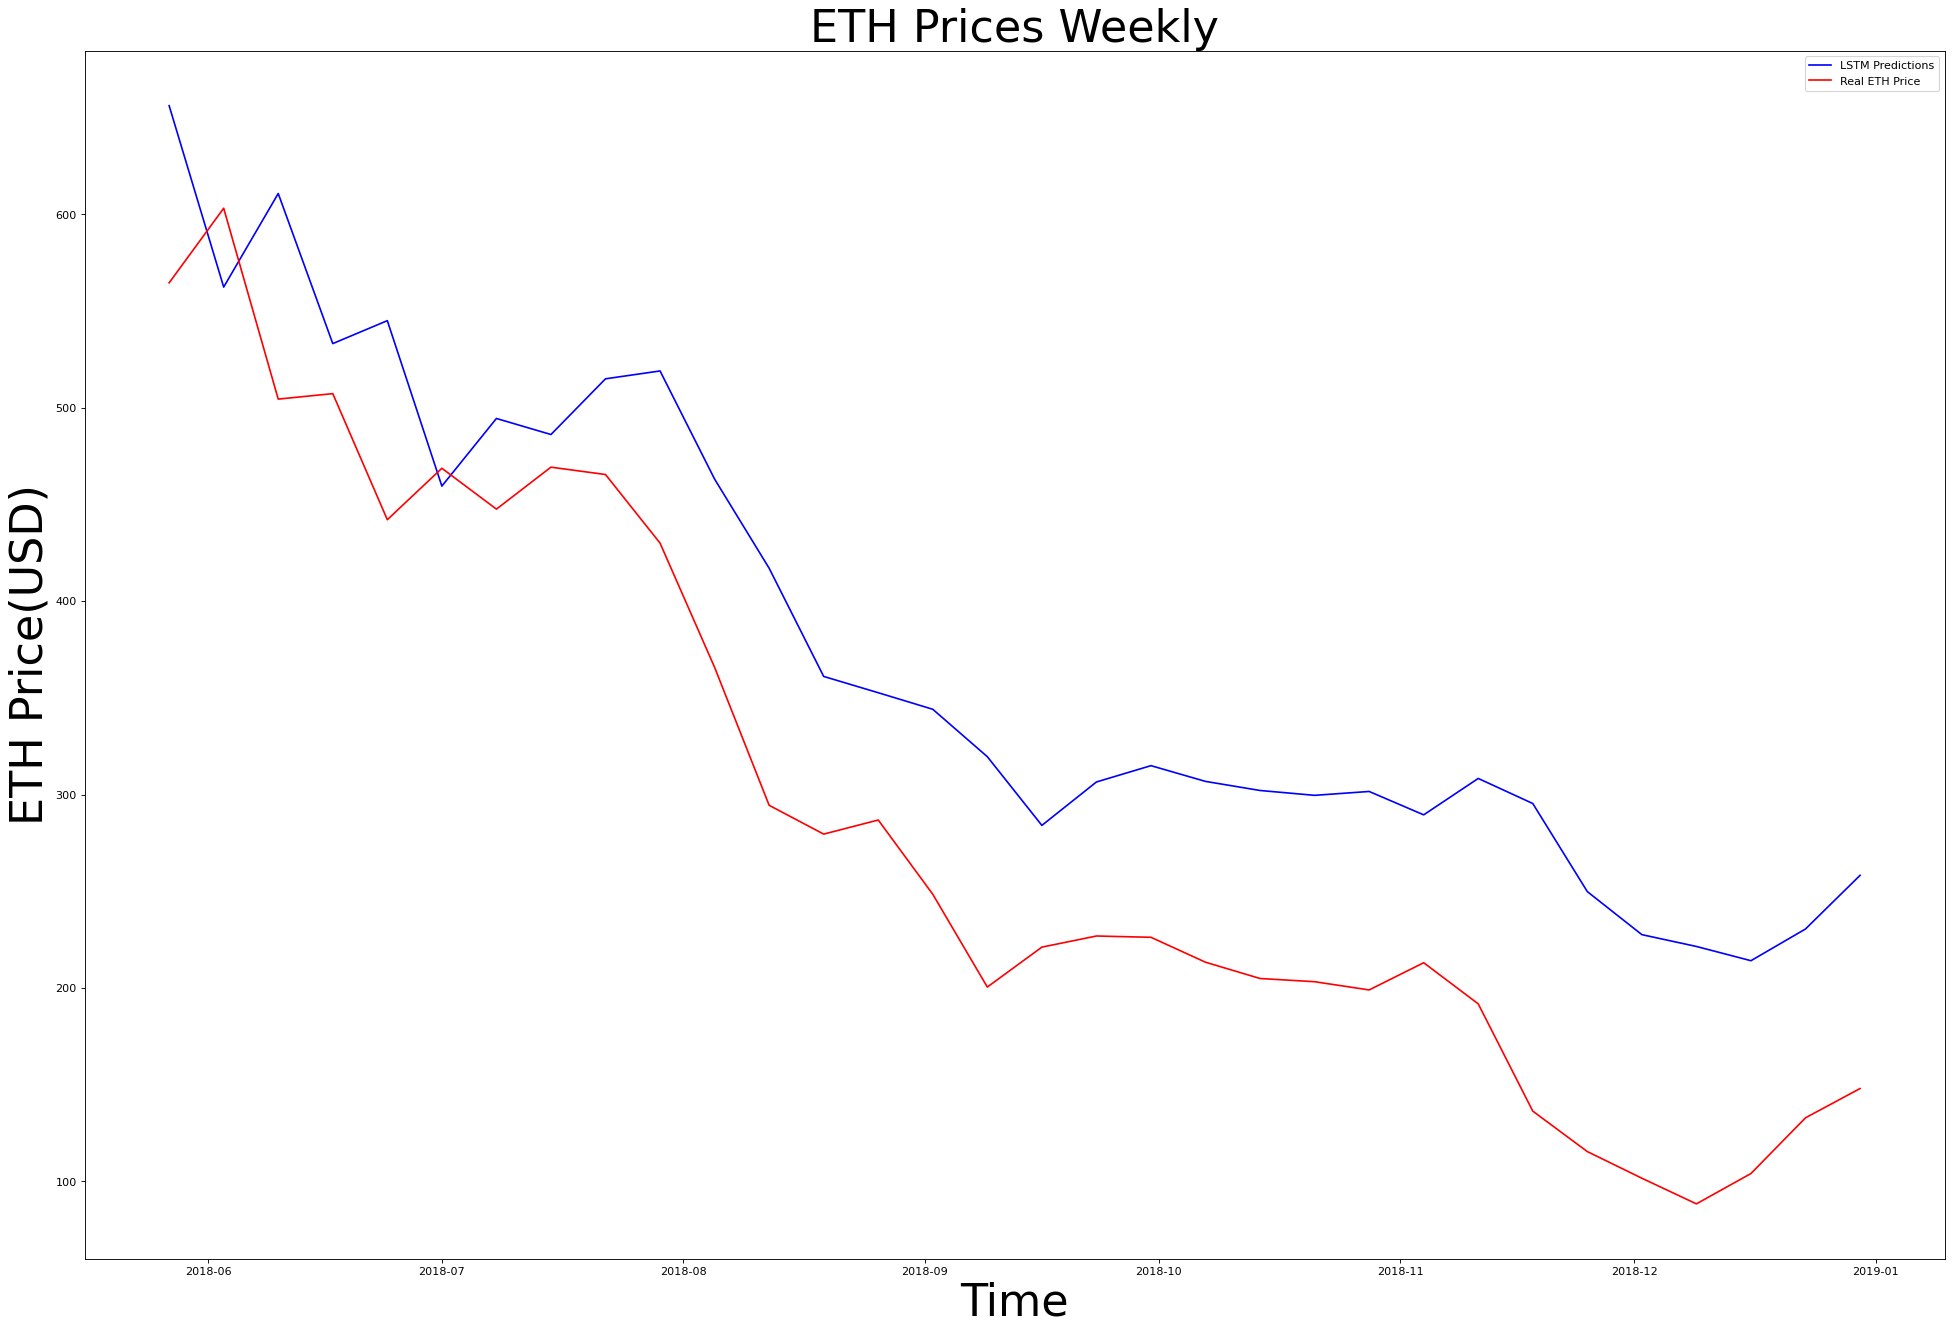

In [41]:
y_test_values = [float(i) for i in y_test]
# The Prices of Bitcoin over time
plt.figure(figsize=(30, 20), dpi=80, facecolor = 'w', edgecolor = 'k')
plt.plot(X_test.index,predicted_price, color='blue', label='LSTM Predictions')
plt.plot(X_test.index,y_test_values, color='red', label='Real ETH Price')
plt.title('ETH Prices Weekly', fontsize = 40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('ETH Price(USD)', fontsize = 40)
plt.legend()
plt.show()

<ipython-input-42-39ecf541e2db>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummy_x['Mean Prices'] = y_train['Mean Weekly Prices']


<AxesSubplot:>

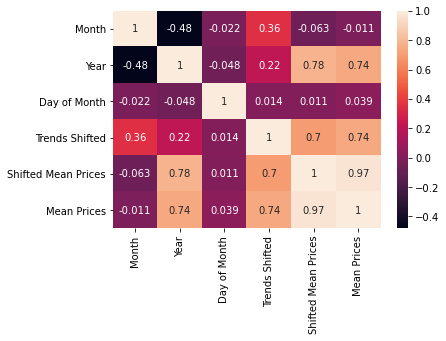

In [42]:
# To see the correlation values
dummy_x = X_train
dummy_x['Mean Prices'] = y_train['Mean Weekly Prices']
sns.heatmap(dummy_x.corr(),annot = True)